### Import neccessary Libraries and utilities functions

In [1]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 7.3 MB/s eta 0:00:00


In [2]:
import gc
from datetime import datetime
import os
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
import plotly.figure_factory as ff
from plotly import tools
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from catboost import CatBoostClassifier
from sklearn import svm
import lightgbm as lgb
import xgboost as xgb

In [3]:
def plotPerColumnDistribution(df, nGraphShown, nGraphPerRow):
    nunique = df.nunique()
    df = df[[col for col in df if 1 < nunique[col] < 50]]  # Pick columns with unique values between 1 and 50
    nRow, nCol = df.shape
    columnNames = list(df)
    nGraphRow = int(np.ceil(nCol / nGraphPerRow))
    plt.figure(figsize=(6 * nGraphPerRow, 8 * nGraphRow), dpi=80, facecolor='w', edgecolor='k')

    for i in range(min(nCol, nGraphShown)):
        plt.subplot(nGraphRow, nGraphPerRow, i + 1)
        columnDf = df.iloc[:, i]
        if not np.issubdtype(columnDf.dtype, np.number):
            valueCounts = columnDf.value_counts()
            ax = valueCounts.plot.bar()
            for p in ax.patches:
                ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))
        else:
            ax = columnDf.hist()
            for p in ax.patches:
                ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))
        plt.ylabel('counts')
        plt.xticks(rotation=90)
        plt.title(f'{columnNames[i]} (column {i})')

    plt.tight_layout(pad=1, w_pad=1, h_pad=1)
    plt.show()

In [4]:
def plotCorrelationMatrix(df, graphWidth):
    filename = df.dataframeName
    df = df.dropna()
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    if df.shape[1] < 2:
        print(f'No correlation plots shown: The number of non-NaN or constant columns ({df.shape[1]}) is less than 2')
        return
    corr = df.corr()
    plt.figure(num=None, figsize=(graphWidth, graphWidth), dpi=80, facecolor='w', edgecolor='k')
    corrMat = plt.matshow(corr, fignum = 1)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.gca().xaxis.tick_bottom()
    plt.colorbar(corrMat)
    plt.title(f'Correlation Matrix for {filename}', fontsize=15)
    plt.show()

In [5]:
# Scatter and density plots
def plotScatterMatrix(df, plotSize, textSize):
    df = df.select_dtypes(include =[np.number])
    df = df.dropna()
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    columnNames = list(df)
    if len(columnNames) > 10: # reduce the number of columns for matrix inversion of kernel density plots
        columnNames = columnNames[:10]
    df = df[columnNames]
    ax = pd.plotting.scatter_matrix(df, alpha=0.75, figsize=[plotSize, plotSize], diagonal='kde')
    corrs = df.corr().values
    for i, j in zip(*plt.np.triu_indices_from(ax, k = 1)):
        ax[i, j].annotate('Corr. coef = %.3f' % corrs[i, j], (0.8, 0.2), xycoords='axes fraction', ha='center', va='center', size=textSize)
    plt.suptitle('Scatter and Density Plot')
    plt.show()

### Load Data

In [6]:
# Install gdown
!pip install -q gdown

import gdown
import pandas as pd
import hashlib

shared_link = 'https://drive.google.com/file/d/1aKYVEOIZZruwHVeUPQ46dm15HJAIEJJH/view?usp=sharing'

file_id = shared_link.split('/')[-2]
dataset_path = 'https://drive.google.com/uc?id=' + file_id

# Download the file
output = '/content/creditcard.csv'
gdown.download(dataset_path, output, quiet=False)

# Read the CSV file
data = pd.read_csv(output)
data.dataframeName = 'creditcard.csv'
nRow, nCol = data.shape

# Print the number of rows and columns
print(f'There are {nRow} rows and {nCol} columns')

Downloading...
From (original): https://drive.google.com/uc?id=1aKYVEOIZZruwHVeUPQ46dm15HJAIEJJH
From (redirected): https://drive.google.com/uc?id=1aKYVEOIZZruwHVeUPQ46dm15HJAIEJJH&confirm=t&uuid=1e1071f4-69e6-43f2-965d-e78e15a4e8c4
To: /content/creditcard.csv
100%|██████████| 151M/151M [00:02<00:00, 54.7MB/s]


There are 284807 rows and 31 columns


### Prediction without resampling and handle imbalance

In [9]:
target = 'Class'
predictors = ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',\
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19',\
       'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28',\
       'Amount']

In [8]:
from sklearn.model_selection import train_test_split, KFold

VALID_SIZE = 0.20
TEST_SIZE = 0.20

NUMBER_KFOLDS = 5

# Other settings
RANDOM_STATE = 2024
MAX_ROUNDS = 1000
EARLY_STOP = 50
OPT_ROUNDS = 1000
VERBOSE_EVAL = 50
IS_LOCAL = False

train_df, test_df = train_test_split(data, test_size=TEST_SIZE, random_state=RANDOM_STATE, shuffle=True )
train_df, valid_df = train_test_split(train_df, test_size=VALID_SIZE, random_state=RANDOM_STATE, shuffle=True )

#### Random Forest Classifier

In [ ]:
# Pandas settings
pd.set_option('display.max_columns', 100)

# Random Forest Classifier settings
RFC_METRIC = 'gini'  # Metric used for RandomForestClassifier
NUM_ESTIMATORS = 100  # Number of estimators used for RandomForestClassifier
NO_JOBS = 4  # Number of parallel jobs used for RandomForestClassifier

clf = RandomForestClassifier(n_jobs=NO_JOBS,
                             random_state=RANDOM_STATE,
                             criterion=RFC_METRIC,
                             n_estimators=NUM_ESTIMATORS,
                             verbose=False)

In [ ]:
clf.fit(train_df[predictors], train_df[target].values)
preds = clf.predict(valid_df[predictors])

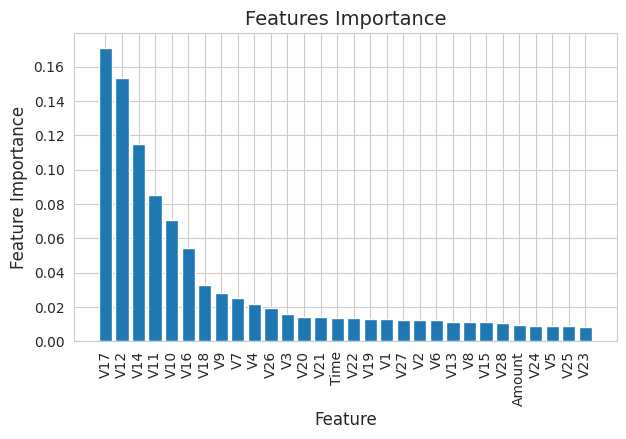

In [ ]:
# Create a DataFrame with feature names and their importance scores
tmp = pd.DataFrame({'Feature': predictors, 'Feature importance': clf.feature_importances_})

# Sort the DataFrame by feature importance in descending order
tmp = tmp.sort_values(by='Feature importance',ascending=False)

# Create a figure and axis object
plt.figure(figsize = (7,4))

# Plotting the bar chart
plt.bar(tmp['Feature'], tmp['Feature importance'])

# Adding title and labels
plt.title('Features Importance', fontsize=14)
plt.xlabel('Feature', fontsize=12)
plt.ylabel('Feature Importance', fontsize=12)

# Rotating x-axis labels for better readability
plt.xticks(rotation=90)

# Display the plot
plt.show()


We could see that most important features are V17, V12, V14, V10, V11, V16.

In [ ]:
import plotly.graph_objs as go

cm = pd.crosstab(valid_df[target].values, preds, rownames=['Actual'], colnames=['Predicted'])

heatmap = go.Heatmap(z=cm.values,
                     x=['Not Fraud', 'Fraud'],
                     y=['Not Fraud', 'Fraud'],
                     colorscale='Blues',
                     hoverinfo='z'  # Show the actual values on hover
                    )

# Define layout settings
layout = go.Layout(
    title='Confusion Matrix',  # Set the title
    xaxis=dict(title='Predicted'),  # Set the x-axis label
    yaxis=dict(title='Actual'),  # Set the y-axis label
)
fig = go.Figure(data=[heatmap], layout=layout)

iplot(fig)
# You can hover to see the number

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

roc_auc = roc_auc_score(valid_df[target].values, preds)
print("ROC AUC Score:", roc_auc)

class_report = classification_report(valid_df[target].values, preds)
print("Classification Report:")
print(class_report)

conf_matrix = confusion_matrix(valid_df[target].values, preds)
print("Confusion Matrix:")
print(conf_matrix)

ROC AUC Score: 0.9025424478800897
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     45492
           1       0.93      0.81      0.86        77

    accuracy                           1.00     45569
   macro avg       0.96      0.90      0.93     45569
weighted avg       1.00      1.00      1.00     45569

Confusion Matrix:
[[45487     5]
 [   15    62]]


Using Random Forest Classifier we got AUC as 0.9, which is not bad

#### Support Vector Machine

In [ ]:
from sklearn.svm import SVC

# SVM settings
SVC_KERNEL = 'linear'
SVC_C = 1.0

svm_clf = SVC(kernel=SVC_KERNEL, C=SVC_C)

# Train the SVM classifier
svm_clf.fit(train_df[predictors], train_df[target].values)

# Make predictions on the validation set
svm_preds = svm_clf.predict(valid_df[predictors])


In [ ]:
import numpy as np

# Get the coefficients of the linear SVM
svm_coef = svm_clf.coef_[0]

# Create a DataFrame with feature names and their coefficients
tmp = pd.DataFrame({'Feature': predictors, 'Coefficient': np.abs(svm_coef)})

# Sort the DataFrame by coefficient magnitude in descending order
tmp = tmp.sort_values(by='Coefficient', ascending=False)

bar_trace = go.Bar(
    x=tmp['Feature'],  # x-axis values
    y=tmp['Coefficient'],  # y-axis values
    marker=dict(color='blue'),  # bar color
)

layout = go.Layout(
    title='Feature Coefficients',  # title
    xaxis=dict(title='Feature'),  # x-axis label
    yaxis=dict(title='Coefficient Magnitude'),  # y-axis label
)

fig = go.Figure(data=[bar_trace], layout=layout)

iplot(fig)


KeyboardInterrupt: 

In [ ]:
import plotly.graph_objs as go

# Create a DataFrame with the confusion matrix data
cm = pd.crosstab(valid_df[target].values, svm_preds, rownames=['Actual'], colnames=['Predicted'])

# Define the data trace for the heatmap
heatmap = go.Heatmap(z=cm.values,
                     x=['Not Fraud', 'Fraud'],
                     y=['Not Fraud', 'Fraud'],
                     colorscale='Blues',  # Set the color scale
                     hoverinfo='z'  # Show the actual values on hover
                    )

# Define layout settings
layout = go.Layout(
    title='Confusion Matrix',  # Set the title
    xaxis=dict(title='Predicted'),  # Set the x-axis label
    yaxis=dict(title='Actual'),  # Set the y-axis label
)

# Create the figure object
fig = go.Figure(data=[heatmap], layout=layout)

# Render the plot
iplot(fig)


In [ ]:
roc_auc_score(valid_df[target].values, svm_preds)

0.5

#### CatBoost Classifier

In [12]:
catboost = CatBoostClassifier(iterations=500,
                             learning_rate=0.02,
                             depth=12,
                             eval_metric='AUC',
                             random_seed = RANDOM_STATE,
                             bagging_temperature = 0.2,
                             od_type='Iter',
                             metric_period = VERBOSE_EVAL,
                             od_wait=100)

In [13]:
catboost.fit(train_df[predictors], train_df[target].values,verbose=True)

0:	total: 897ms	remaining: 7m 27s
50:	total: 31.4s	remaining: 4m 36s
100:	total: 59.6s	remaining: 3m 55s
150:	total: 1m 28s	remaining: 3m 23s
200:	total: 1m 59s	remaining: 2m 58s
250:	total: 2m 28s	remaining: 2m 27s
300:	total: 2m 58s	remaining: 1m 57s
350:	total: 3m 28s	remaining: 1m 28s
400:	total: 3m 57s	remaining: 58.7s
450:	total: 4m 32s	remaining: 29.6s
499:	total: 5m 1s	remaining: 0us


CatBoostError: There is no trained model to use predict(). Use fit() to train model. Then use this method.

In [14]:
catboost_preds = catboost.predict(valid_df[predictors])

<ipython-input-14-e1148afbac45>:6: UserWarning:

FixedFormatter should only be used together with FixedLocator



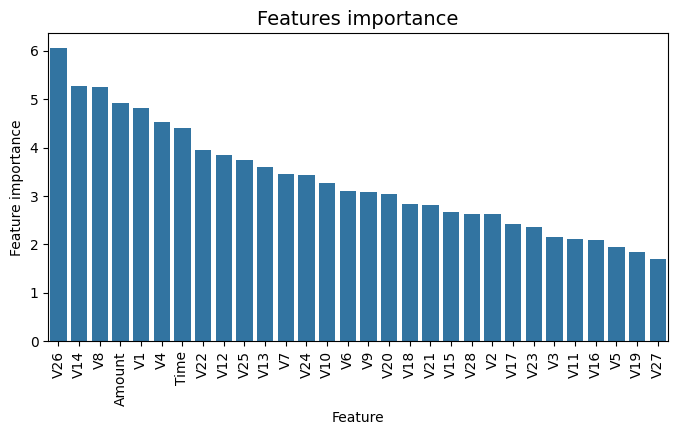

In [ ]:
tmp = pd.DataFrame({'Feature': predictors, 'Feature importance': catboost.feature_importances_})
tmp = tmp.sort_values(by='Feature importance',ascending=False)
plt.figure(figsize = (8,4))
plt.title('Features importance',fontsize=14)
s = sns.barplot(x='Feature',y='Feature importance',data=tmp)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show()

In [ ]:
import plotly.graph_objs as go

cm = pd.crosstab(valid_df[target].values, catboost_preds, rownames=['Actual'], colnames=['Predicted'])

heatmap = go.Heatmap(z=cm.values,
                     x=['Not Fraud', 'Fraud'],
                     y=['Not Fraud', 'Fraud'],
                     colorscale='Blues',
                     hoverinfo='z'  # Show the actual values on hover
                    )

# Define layout settings
layout = go.Layout(
    title='Confusion Matrix',  # Set the title
    xaxis=dict(title='Predicted'),  # Set the x-axis label
    yaxis=dict(title='Actual'),  # Set the y-axis label
)
fig = go.Figure(data=[heatmap], layout=layout)

iplot(fig)
# You can hover to see the number

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

roc_auc = roc_auc_score(valid_df[target].values, catboost_preds)
print("ROC AUC Score:", roc_auc)

class_report = classification_report(valid_df[target].values, catboost_preds)
print("Classification Report:")
print(class_report)

conf_matrix = confusion_matrix(valid_df[target].values, catboost_preds)
print("Confusion Matrix:")
print(conf_matrix)

ROC AUC Score: 0.9090469453170589
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     45492
           1       0.94      0.82      0.88        77

    accuracy                           1.00     45569
   macro avg       0.97      0.91      0.94     45569
weighted avg       1.00      1.00      1.00     45569

Confusion Matrix:
[[45488     4]
 [   14    63]]


#### Multi Layer Perceptron

In [ ]:
MLPC = MLPClassifier(hidden_layer_sizes=(200,), max_iter=10000)
MLPC.fit(train_df[predictors], train_df[target].values)
MLP_pred = MLPC.predict(valid_df[predictors])

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

roc_auc = roc_auc_score(valid_df[target].values, MLP_pred)
print("ROC AUC Score:", roc_auc)

class_report = classification_report(valid_df[target].values, MLP_pred)
print("Classification Report:")
print(class_report)

conf_matrix = confusion_matrix(valid_df[target].values, MLP_pred)
print("Confusion Matrix:")
print(conf_matrix)

ROC AUC Score: 0.49997801811307485
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     45492
           1       0.00      0.00      0.00        77

    accuracy                           1.00     45569
   macro avg       0.50      0.50      0.50     45569
weighted avg       1.00      1.00      1.00     45569

Confusion Matrix:
[[45490     2]
 [   77     0]]


#### LightGBM

In [ ]:
params = {
          'boosting_type': 'gbdt',
          'objective': 'binary',
          'metric':'auc',
          'learning_rate': 0.05,
          'num_leaves': 7,  # we should let it be smaller than 2^(max_depth)
          'max_depth': 4,  # -1 means no limit
          'min_child_samples': 100,  # Minimum number of data need in a child(min_data_in_leaf)
          'max_bin': 100,  # Number of bucketed bin for feature values
          'subsample': 0.9,  # Subsample ratio of the training instance.
          'subsample_freq': 1,  # frequence of subsample, <=0 means no enable
          'colsample_bytree': 0.7,  # Subsample ratio of columns when constructing each tree.
          'min_child_weight': 0,  # Minimum sum of instance weight(hessian) needed in a child(leaf)
          'min_split_gain': 0,  # lambda_l1, lambda_l2 and min_gain_to_split to regularization
          'nthread': 8,
          'verbose': 0,
          'scale_pos_weight':150, # because training data is extremely unbalanced
         }

In [ ]:
dtrain = lgb.Dataset(train_df[predictors].values,
                     label=train_df[target].values,
                     feature_name=predictors)

dvalid = lgb.Dataset(valid_df[predictors].values,
                     label=valid_df[target].values,
                     feature_name=predictors)

In [ ]:
evals_results = {}

model = lgb.train(params,
                  dtrain,
                  valid_sets=[dtrain, dvalid],
                  valid_names=['train','valid'],
#                   evals_result=evals_results,
                  num_boost_round=MAX_ROUNDS,
#                   early_stopping_round=2*EARLY_STOP,
#                   verbose_eval=VERBOSE_EVAL,
                  feval=None)



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No furthe

In [ ]:
lgb_preds = model.predict(valid_df[predictors])

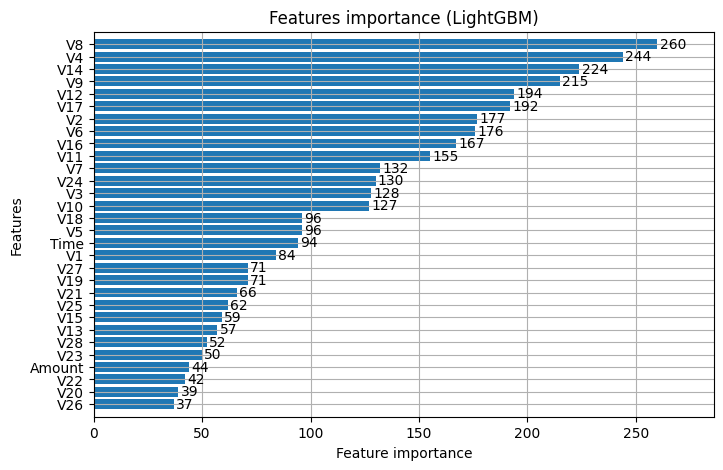

In [ ]:
fig, (ax) = plt.subplots(ncols=1, figsize=(8,5))
lgb.plot_importance(model, height=0.8, title="Features importance (LightGBM)", ax=ax)
plt.show()

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

roc_auc = roc_auc_score(valid_df[target].values, lgb_preds)
print("ROC AUC Score:", roc_auc)

class_preds = (lgb_preds >= 0.5).astype(int)

class_report = classification_report(valid_df[target].values, class_preds)
print("Classification Report:")
print(class_report)

conf_matrix = confusion_matrix(valid_df[target].values, class_preds)
print("Confusion Matrix:")
print(conf_matrix)


ROC AUC Score: 0.79895751614955
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.95      0.97     45492
           1       0.02      0.65      0.04        77

    accuracy                           0.95     45569
   macro avg       0.51      0.80      0.51     45569
weighted avg       1.00      0.95      0.97     45569

Confusion Matrix:
[[43157  2335]
 [   27    50]]


#### Test with test set

Catboost yields the best result, we will test CatBoost with test set

In [15]:
cb_preds = catboost.predict(test_df[predictors])

In [17]:
from sklearn.metrics import classification_report, confusion_matrix

roc_auc = roc_auc_score(test_df[target].values, cb_preds)
print("ROC AUC Score:", roc_auc)

class_report = classification_report(test_df[target].values, cb_preds)
print("Classification Report:")
print(class_report)

conf_matrix = confusion_matrix(test_df[target].values, cb_preds)
print("Confusion Matrix:")
print(conf_matrix)

ROC AUC Score: 0.8624736110622427
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56842
           1       0.97      0.72      0.83       120

    accuracy                           1.00     56962
   macro avg       0.98      0.86      0.91     56962
weighted avg       1.00      1.00      1.00     56962

Confusion Matrix:
[[56839     3]
 [   33    87]]
